
# PW8 - Transfer learning and Fine Tuning



Objective : use a pretrained network to classify new data with transfer learning and fine tuning. A data augmentation strategy is used to elaborate the training set.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

PATH_TO_ROOT = "/content/drive/MyDrive/Colab-Notebooks/Deep-Learning-Python/08-transfer-learning/"

Mounted at /content/drive


# Imports

In [ ]:
import tensorflow as tf
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model

#Feel free to change the pretrained network
from tensorflow.keras.applications import MobileNetV2, ResNet50

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam


In [ ]:
# Parameters (image size depends on the pretrained model)
image_shape = (224, 224, 3)
image_size = image_shape[:2]
print(image_size)

batch_size = 32    
num_classes = 5 # daisy, dandelion, roses, sunflowers, tulips

(224, 224)


# Data 

The new data we want to classify is composed of 5 species of flowers: daisy, dandelion, roses, sunflowers, tulips. The dataset is composed of various images collected from Internet, with various sizes and shooting conditions.
We use [ImageDataGenerator](https://keras.io/api/preprocessing/image/) to do data augmentation. We only allow rotations.

In [ ]:
def Data():
    data_dir = get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',fname='flower_photos',cache_dir = './',untar=True)
    data_dir = pathlib.Path(data_dir)

    print("# of images :", len(list(data_dir.glob('*/*.jpg'))))

    classes = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
    print("Classes : ",classes)
    

    # Data Augmentation: 75% for training, 25% for test. On
    image_gen = ImageDataGenerator(rescale=1/255, rotation_range=20,validation_split=0.25)

    # Increasing the training set size.
    # To save the created images, use  save_to_dir
    train_data_gen = image_gen.flow_from_directory(directory=str(data_dir), batch_size=batch_size,
                                                        classes=list(classes), target_size=(image_size[0], image_size[1]),
                                                        shuffle=True, subset="training")
    # Increasing the test/validation set size.
    test_data_gen = image_gen.flow_from_directory(directory=str(data_dir), batch_size=batch_size, 
                                                        classes=list(classes), target_size=(image_size[0], image_size[1]),
                                                        shuffle=True, subset="validation")
    return train_data_gen, test_data_gen, classes


In [ ]:
# Data + augmented data
x_train, x_test, classes = Data()

228818944/228813984 [==============================] - 3s 0us/step
# of images : 3670
Classes :  ['sunflowers' 'dandelion' 'roses' 'daisy' 'tulips']
Found 2755 images belonging to 5 classes.
Found 915 images belonging to 5 classes.


In [ ]:
#y_train = x_train.labels
#y_test = x_test.labels

Function defining the pretrained model. 
- Load an existing model (here a very simple and light model: <font color='red'>try others</font> (see lecture 04 - Architectures))
- The last layer is removed (using the [pop](https://keras.io/api/models/sequential/) function), 
- the network is prepared for finetuning (the last `stop_freeze` layers), you can access to the layers of the model using `model.layers`. Make the first ones, up to `stop_freze`, not trainable
- a new final classification layer is added, composed of a [Flatten](https://keras.io/api/layers/reshaping_layers/flatten/) layer, and a Dense layer (with [softmax activation](https://keras.io/api/layers/activations/)) for classification. <font color='red'>Feel free to refine if needed</font>

In [ ]:
def newModel(input_shape,stop_freeze):

  #TODO
  pretrained_model = MobileNetV2(input_shape=input_shape, include_top=False)
  #pretrained_model.layers.pop()

  for layer in pretrained_model.layers[:-stop_freeze]:
    layer.trainable = False

  model = Sequential([pretrained_model, Flatten(),
                      Dense(num_classes, activation="softmax")])
  
  return model
 

# Network definition
Define your model, and add the `categorical_crossentropy`loss optimized with `Adam`. Track the accuracy.

In [ ]:
num_epochs = 10
stop_freeze = 4

input = [*image_size,3]
model = newModel(input, stop_freeze)

adam = Adam()
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=['accuracy'])

#model.fit(x=x_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_data=x_test)

#TODO
model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 5)                 313605    
Total params: 2,571,589
Trainable params: 726,405
Non-trainable params: 1,845,184
_________________________________________________________________


In [ ]:
# Callback saving only the best model
if not os.path.isdir("save"):
    os.mkdir("save")
    
checkpoint = ModelCheckpoint(PATH_TO_ROOT+"save/MobileNetV2_flowers-loss-{val_loss:.2f}-acc-{accuracy:.2f}.h5",save_best_only=True,verbose=1)

train_steps_epoch = np.ceil(x_train.samples / batch_size)
val_steps_epoch = np.ceil(x_test.samples / batch_size)

# Model fitting
history = model.fit(x_train, steps_per_epoch=train_steps_epoch,
                        validation_data=x_test, validation_steps=val_steps_epoch,
                        epochs=num_epochs, verbose=1, callbacks=[checkpoint])

Epoch 1/10
87/87 [==============================] - 88s 640ms/step - loss: 3.3198 - accuracy: 0.6728 - val_loss: 4.7181 - val_accuracy: 0.7770

Epoch 00001: val_loss improved from inf to 4.71811, saving model to /content/drive/MyDrive/Colab-Notebooks/Deep-Learning-Python/08-transfer-learning/save/MobileNetV2_flowers-loss-4.72-acc-0.76.h5
Epoch 2/10
87/87 [==============================] - 54s 620ms/step - loss: 1.1395 - accuracy: 0.9027 - val_loss: 3.9658 - val_accuracy: 0.8000

Epoch 00002: val_loss improved from 4.71811 to 3.96580, saving model to /content/drive/MyDrive/Colab-Notebooks/Deep-Learning-Python/08-transfer-learning/save/MobileNetV2_flowers-loss-3.97-acc-0.91.h5
Epoch 3/10
87/87 [==============================] - 54s 624ms/step - loss: 0.7804 - accuracy: 0.9240 - val_loss: 5.7640 - val_accuracy: 0.8087

Epoch 00003: val_loss did not improve from 3.96580
Epoch 4/10
87/87 [==============================] - 54s 625ms/step - loss: 0.7190 - accuracy: 0.9408 - val_loss: 6.8735 -

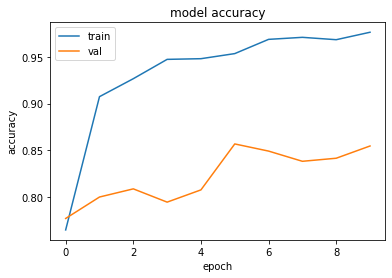

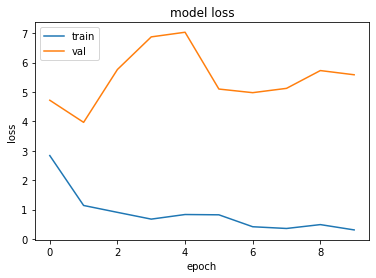

<Figure size 432x288 with 0 Axes>

In [ ]:
# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.tight_layout()

### Content of the save folder: best model
Define the best model using the optimal weights. Load the weights of the best model (using the [load_weights](https://keras.io/api/models/model_saving_apis/#load_weights-method) method) and evaluate it on the test set
Remind that you have to compile again the model.

In [ ]:
!ls -al save

total 8
drwxr-xr-x 2 root root 4096 May 21 08:27 .
drwxr-xr-x 1 root root 4096 May 21 08:27 ..


In [ ]:
# Best trained model
#TODO
model = newModel(input_shape=image_shape, stop_freeze=stop_freeze)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Load the good weights (see in the name in the directory)
#TODO
model.load_weights(PATH_TO_ROOT+"/save/MobileNetV2_flowers-loss-3.97-acc-0.91.h5")

# Model evaluation
#TODO
evaluation = model.evaluate(x_test, steps=val_steps_epoch, verbose=1)
print("Loss = {0:5.3f}, Accuracy = {1:5.3f}".format(evaluation[0], evaluation[1]))

29/29 [==============================] - 15s 451ms/step - loss: 4.2280 - accuracy: 0.8112
Loss = 3.939, Accuracy = 0.819


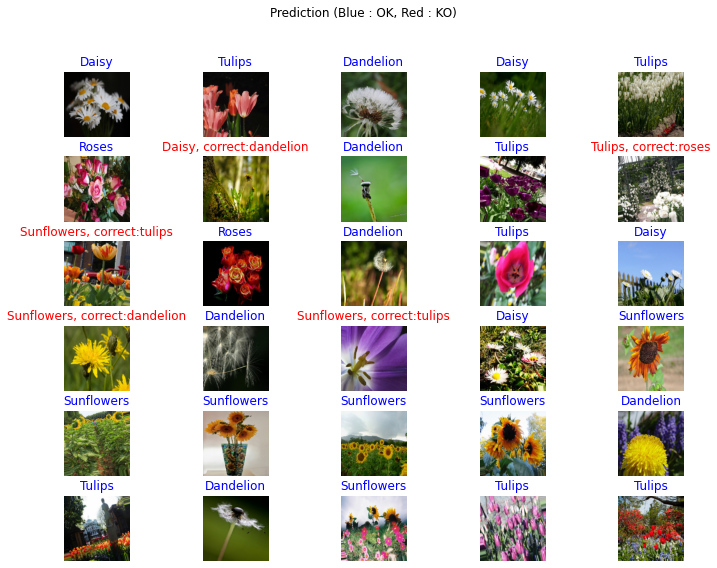

In [ ]:
# Good and bad classification examples
image_batch, label_batch = next(iter(x_test))

label_batch = [classes[np.argmax(label_batch[i])] for i in range(batch_size)]
predicted_classes = model.predict(image_batch)

predicted_ids = [np.argmax(predicted_classes[i]) for i in range(batch_size)]
predicted_classes = np.array([classes[id] for id in predicted_ids])

plt.figure(figsize=(12,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    if predicted_classes[n] == label_batch[n]:
        color = "blue"
        title = predicted_classes[n].title()
    else:
        color = "red"
        title = f"{predicted_classes[n].title()}, correct:{label_batch[n]}"
    plt.title(title, color=color)
    plt.axis('off')
_ = plt.suptitle("Prediction (Blue : OK, Red : KO)")
plt.show()
